In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings("ignore")
sys.path.append("../")

from src.segtool.config import DataConfig, TrainConfig
from src.segtool.data import (
    make_loaders,
    DefectSegDataset,
    DatasetPaths,
    default_paths,
    find_mask
)
from src.segtool.model import UNet
from src.segtool.models_factory import build_model
from src.segtool.losses import BCEDiceLoss, DiceLoss
from src.segtool.engine import (
    train_one_epoch,
    validate,
    EpochResult,
    _defect_only_metrics
)
from src.segtool.metrics import compute_metrics, reduce_mean, Metrics
from src.segtool.utils import *

In [2]:
set_seed(42)
device = get_device()
print(device)

mps


In [3]:
# Colab root
# dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
# Local root
dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(144, 256),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=8, # mps
    num_workers=2
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 840
Val: 180
Test: 180


In [4]:
unet = UNet(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 466,529
Trainable parameters: 466,529


In [6]:
# optimizer
optimizer = torch.optim.Adam(
    unet.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {unet.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
# print(f"Dropout: {getattr(unet.dropout, 'p', 0.0)}")

Device: mps
Model: UNet
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 8
Learning rate: 0.001


In [7]:
train_losses = []
val_losses = []
train_dices = []
val_dices = []
val_defect_dices = []

epochs = 10
best_val_dice = -1.0
threshold = 0.5

print(f"Starting Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=unet,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=unet,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    train_losses.append(train_result.loss)
    val_losses.append(val_result.loss)
    train_dices.append(train_result.metrics_all.dice)
    val_dices.append(val_result.metrics_all.dice) # 모든 샘플에 대해 계산 (정상 포함)
    val_defect_dices.append(val_result.metrics_defect_only.dice) # 결함이 있는 샘플만 계산

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > best_val_dice:
        best_val_dice = val_result.metrics_defect_only.dice

print("\nTraining completed!")
print(f"Best Validation Defect Dice: {best_val_dice:.4f}")

Starting Training for 10 epochs
Epoch 1/10
Train - Loss: 0.5500 | Dice: 0.0006
Val - Loss: 0.5146 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/10
Train - Loss: 0.3728 | Dice: 0.3001
Val - Loss: 0.2303 | Dice: 0.5996 | Defect Dice: 0.6146
------------------------------------------------------------
Epoch 3/10
Train - Loss: 0.2299 | Dice: 0.5989
Val - Loss: 0.1759 | Dice: 0.7112 | Defect Dice: 0.7129
------------------------------------------------------------
Epoch 4/10
Train - Loss: 0.1676 | Dice: 0.7137
Val - Loss: 0.1566 | Dice: 0.7335 | Defect Dice: 0.7412
------------------------------------------------------------
Epoch 5/10
Train - Loss: 0.1437 | Dice: 0.7518
Val - Loss: 0.1403 | Dice: 0.7567 | Defect Dice: 0.7623
------------------------------------------------------------
Epoch 6/10
Train - Loss: 0.1254 | Dice: 0.7843
Val - Loss: 0.1682 | Dice: 0.7045 | Defect Dice: 0.7311
---------------------------------------------

In [8]:
def plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices, 
                        save_path=None, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    # 1. Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Dice Score curves (All samples)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dices, 'b-', label='Train Dice', linewidth=2)
    plt.plot(epochs, val_dices, 'r-', label='Val Dice', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score (All Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Defect-only Dice Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_defect_dices, 'g-', label='Val Dice (Defect)', linewidth=2)
    plt.axhline(y=best_val_dice, color='orange', linestyle='--',
                label=f'Best: {best_val_dice:.4f}')
    plt.axvline(x=best_epoch, color='orange', linestyle=':', alpha=0.7,
                label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Defect-Only Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary
    print_training_summary(train_losses, val_losses, val_dices, val_defect_dices)

def print_training_summary(train_losses, val_losses, val_dices, val_defect_dices):
    """Print training summary statistics"""
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    print(f"TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Val Dice (All): {val_dices[-1]:.4f}")
    print(f"Final Val Dice (Defect): {val_defect_dices[-1]:.4f}")
    print(f"Best Val Dice (Defect): {best_val_dice:.4f}")
    print(f"Best Epoch: {best_epoch}")

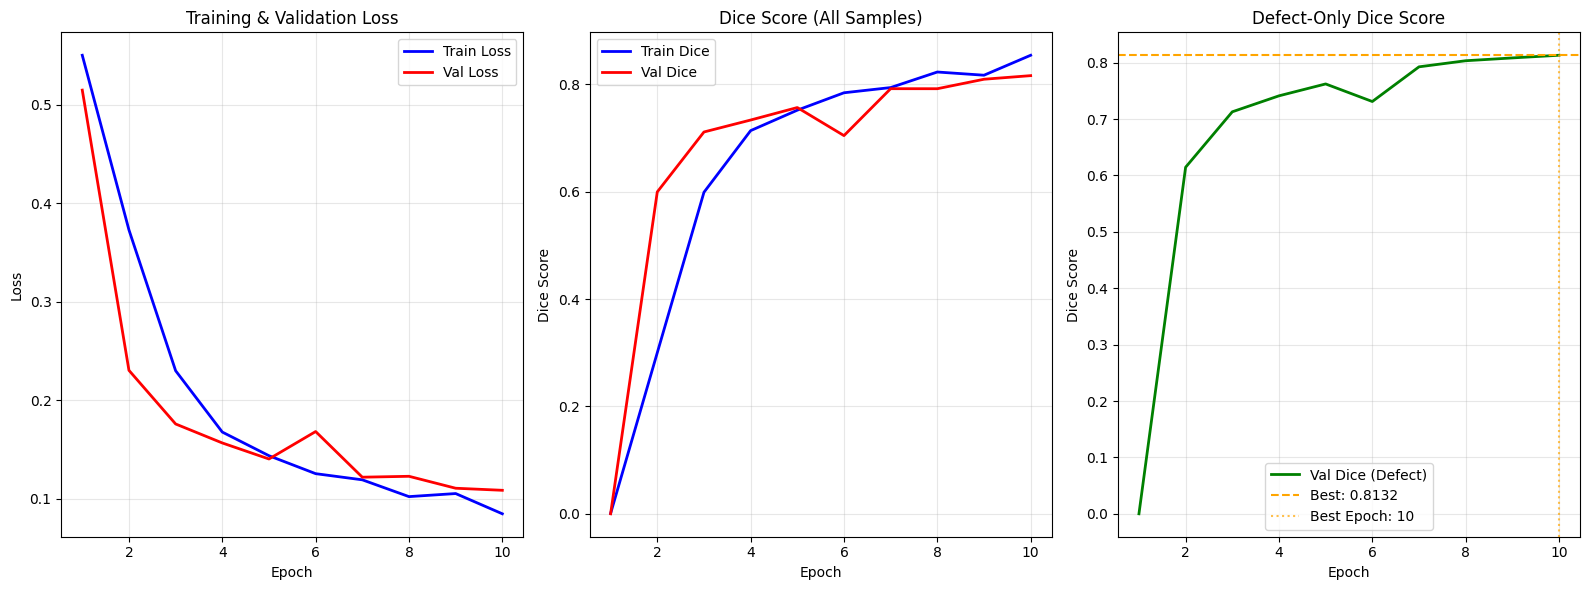

TRAINING SUMMARY
Final Train Loss: 0.0847
Final Val Loss: 0.1086
Final Val Dice (All): 0.8162
Final Val Dice (Defect): 0.8132
Best Val Dice (Defect): 0.8132
Best Epoch: 10


In [9]:
plot_training_history(
    train_losses, 
    val_losses, 
    train_dices, 
    val_dices, 
    val_defect_dices
)

In [10]:
def inference_test_set(model, test_loader, criterion, device, threshold=0.5):
    """Inference model on test set"""
    test_result = validate(
        model=model,
        loader=test_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    print("TEST RESULTS")
    print("=" * 40)
    print(f"Test Loss: {test_result.loss:.4f}")
    print(f"Test Dice (All): {test_result.metrics_all.dice:.4f}")
    print(f"Test IoU (All): {test_result.metrics_all.iou:.4f}")
    print(f"Test Precision (All): {test_result.metrics_all.precision:.4f}")
    print(f"Test Recall (All): {test_result.metrics_all.recall:.4f}")
    print()
    print("DEFECT-ONLY METRICS")
    print("-" * 30)
    print(f"Test Dice (Defects): {test_result.metrics_defect_only.dice:.4f}")
    print(f"Test IoU (Defects): {test_result.metrics_defect_only.iou:.4f}")
    print(f"Test Precision (Defects): {test_result.metrics_defect_only.precision:.4f}")
    print(f"Test Recall (Defects): {test_result.metrics_defect_only.recall:.4f}")

    return test_result

def inference_visualize(model, test_loader, device, threshold=0.5, num_samples=8):
    """Model inference and visualization"""
    model.eval()

    # Get random samples from test set
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(samples) >= num_samples:
                break

            # Unpack 4 items: (images, masks, class_names, file_names)
            images, masks = batch[0], batch[1]
            images = images.to(device)
            masks = masks.to(device)

            # Model prediction
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            # Convert to numpy for visualization
            for j in range(images.size(0)):
                if len(samples) >= num_samples:
                    break

                img = images[j].cpu().permute(1, 2, 0).numpy()
                true_mask = masks[j].cpu().squeeze().numpy()
                pred_mask = preds[j].cpu().squeeze().numpy()
                prob_map = torch.sigmoid(outputs[j]).cpu().squeeze().numpy()

                samples.append({
                    'image': img,
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'prob_map': prob_map
                })

    # Visualization
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))

    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Prediction probability map
        axes[2, i].imshow(sample['prob_map'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title('Probability Map')
        axes[2, i].axis('off')

        # Binary prediction
        axes[3, i].imshow(sample['pred_mask'], cmap='gray')
        axes[3, i].set_title(f'Prediction (>{threshold})')
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

    return samples

TEST RESULTS
Test Loss: 0.0825
Test Dice (All): 0.8574
Test IoU (All): 0.7607
Test Precision (All): 0.8759
Test Recall (All): 0.8586

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.7998
Test IoU (Defects): 0.6942
Test Precision (Defects): 0.7945
Test Recall (Defects): 0.8563


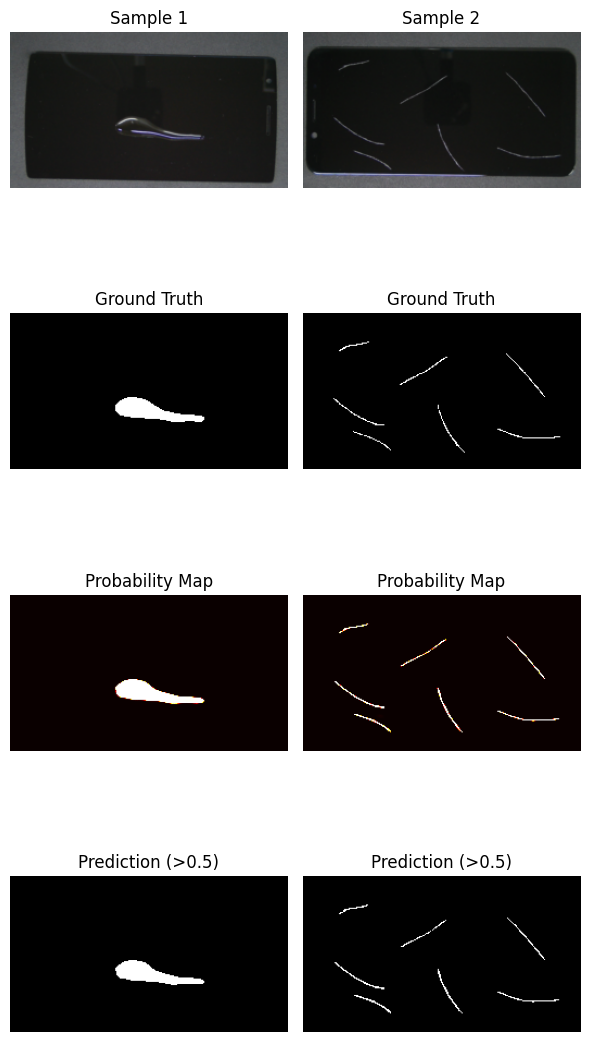

In [11]:
test_result = inference_test_set(unet, test_loader, criterion, device, threshold=0.5)
samples = inference_visualize(unet, test_loader, device, threshold=0.5, num_samples=2)